In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import tree

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import BayesianRidge
class WrappedIterativeImputer(BaseEstimator, TransformerMixin):
    """Wrap IterativeImputer to return One Column Only

    The name of the column to be kept is passed to the constructor.

    This must be the first step in a pipe, as it relies on X being a Pandas DataFrame"""

    def __init__(self, return_col):
        self.ii = IterativeImputer()
        self.return_col = return_col
        self.return_col_idx = None

    def fit(self, X, y):
        self.ii.fit(X, y)
        self.return_col_idx = X.columns.get_loc(self.return_col)

        return self

    def transform(self, X):
        return_col = self.ii.transform(X)[:, self.return_col_idx]

        # must be 2D
        return return_col.reshape(-1, 1)

In [5]:
X, y = tt.get_Xy_v5()
cols_returned, ct = tt.get_ct_v5()

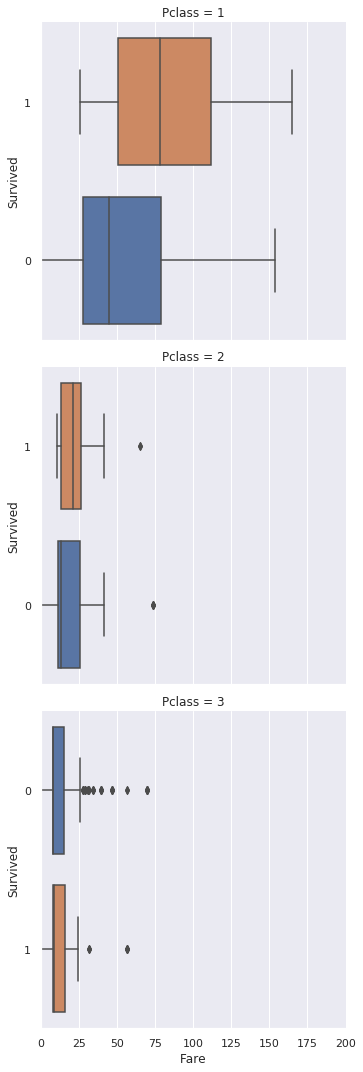

In [5]:
g = sns.catplot(x='Fare', y='Survived', data=all_data, kind='box', 
            orient='h', row='Pclass')
g.axes[0,0].set(xlim=(0,200));

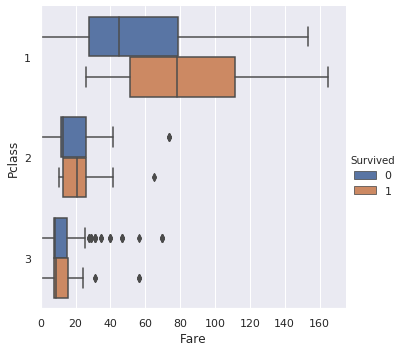

In [6]:
g = sns.catplot(x='Fare', y='Pclass', data=all_data, kind='box', 
            orient='h', hue='Survived')
g.axes[0,0].set(xlim=(0,175));

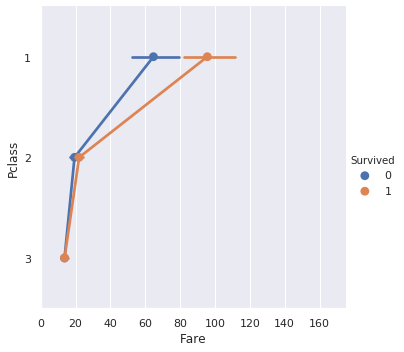

In [7]:
g = sns.catplot(x='Fare', y='Pclass', data=all_data, kind='point', 
            orient='h', hue='Survived')
g.axes[0,0].set(xlim=(0,175));

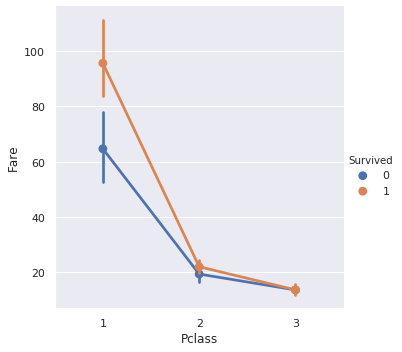

In [8]:
g = sns.catplot(x='Pclass', y='Fare', data=all_data, kind='point', 
            hue='Survived');

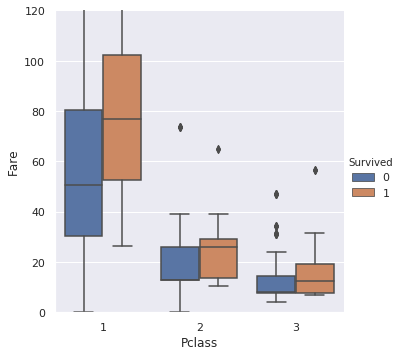

In [9]:
g = sns.catplot(x='Pclass', y='Fare', data=all_data[:400], kind='box', 
            hue='Survived')
g.axes[0,0].set(ylim=(0,120));

In [10]:
# g = sns.catplot(x='Pclass', y='Fare', data=all_data[:400], kind='dist', 
#             row='Survived')
# g.axes[0,0].set(ylim=(0,175));

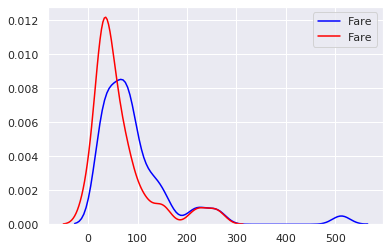

In [11]:
c1 = (all_data['Pclass'] == 1) & (all_data['Survived'] == 1)
c2 = (all_data['Pclass'] == 1) & (all_data['Survived'] == 0)

fig, ax = plt.subplots()
sns.kdeplot(all_data['Fare'][c1], ax=ax, color='blue')
sns.kdeplot(all_data['Fare'][c2], color='red');
# ax.set(xlim=(0,180));

In [12]:
for pclass in [1, 2, 3]:
    c = (all_data['Pclass'] == pclass)
    print(all_data['Fare'][c].mean(), all_data['Fare'][c].std()/2)

84.1546874999999 39.19018632336442
20.662183152173917 6.708699378074667
13.675550101833004 5.889070852193654


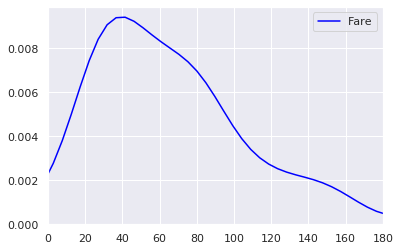

In [13]:
c1 = (all_data['Pclass'] == 1)

fig, ax = plt.subplots()
sns.kdeplot(all_data['Fare'][c1], ax=ax, color='blue')
ax.set(xlim=(0,180));

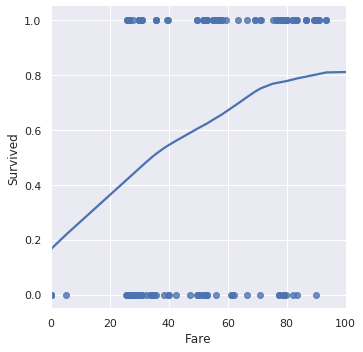

In [14]:
g =sns.lmplot(x='Fare', y='Survived', data=all_data[all_data['Pclass'] == 1],
           lowess=True)
# g =sns.lmplot(x='Fare', y='Survived', data=all_data[all_data['Pclass'] == 2],
#            lowess=True)
# g =sns.lmplot(x='Fare', y='Survived', data=all_data[all_data['Pclass'] == 3],
#            lowess=True)
g.axes[0,0].set(xlim=(0,100));

In [15]:
cutoff = 60.3 # 54, 77
c1 = (all_data['Pclass'] == 1) & (all_data['Fare'] > cutoff)
c2 = (all_data['Pclass'] == 1) & (all_data['Fare'] <= cutoff)
all_data['Survived'][c1].mean(), all_data['Survived'][c2].mean()

(0.7407407407407407, 0.5185185185185185)

In [16]:
all_data['Survived'][c1].sum(), all_data['Survived'][c2].sum()

(80, 56)

In [17]:
all_data['Fare'][(all_data['Pclass'] == 1) & (all_data['Survived'] == 1)].median()

77.9583

In [18]:
all_data['Fare'][all_data['Pclass'] == 1].median()

60.287499999999994

In [19]:
c1 = (all_data['Pclass'] == 1) & (all_data['Survived'] == 1)
all_data['Fare'][c1].median()

77.9583

In [20]:
all_data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [21]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
tmp = all_data[all_data['Pclass'] == 2]
X = tmp[['Fare']]
y = tmp['Survived']
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

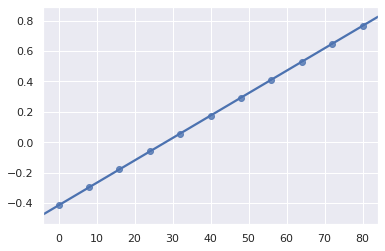

In [22]:
x = np.linspace(0, 80, 11)
sns.regplot(x=x, y =clf.decision_function(x.reshape(-1,1)));
# list(zip(x, clf.decision_function(x.reshape(-1,1))))

In [23]:
clf.predict(x.reshape(-1,1))

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [24]:
from sklearn.base import TransformerMixin, BaseEstimator
class AdjPclass(BaseEstimator, TransformerMixin):
    """Some Description
    """

    def __init__(self):
        self.ss1 = StandardScaler()
        self.ss2 = StandardScaler()
        self.ss3 = StandardScaler()

    def fit(self, X, y):
        """X be DataFrame with Pclass and Fare"""
        
        c1 = (X['Pclass'] == 1)
        c2 = (X['Pclass'] == 2)
        c3 = (X['Pclass'] == 3)
        
        self.ss1.fit(X[['Fare']][c1], y)
        self.ss2.fit(X[['Fare']][c2], y)
        self.ss3.fit(X[['Fare']][c3], y)

        return self

    def transform(self, X):
        
        X_tmp = X[['Fare', 'Pclass']].copy()
        
        c1 = (X['Pclass'] == 1)
        c2 = (X['Pclass'] == 2)
        c3 = (X['Pclass'] == 3)
        
        X_tmp['adj_pclass'] = X['Pclass'].copy()
        X_tmp.loc[c1, 'adj_pclass'] -= self.ss1.transform(X[['Fare']][c1]).squeeze()/2
        X_tmp.loc[c2, 'adj_pclass'] -= self.ss1.transform(X[['Fare']][c2]).squeeze()/2
        X_tmp.loc[c3, 'adj_pclass'] -= self.ss1.transform(X[['Fare']][c3]).squeeze()/2 - 1.0       

        # must be 2D
        return X_tmp[['adj_pclass']].copy()

In [25]:
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [26]:
adj_pclass = AdjPclass()

In [27]:
y = all_data['PassengerId']
adj_pclass.fit(all_data, y)

AdjPclass()

In [28]:
all_data['adj_pclass'] = adj_pclass.transform(all_data)

In [29]:
all_data[['Pclass', 'Fare', 'adj_pclass']].tail(12)

,Pclass,Fare,adj_pclass
879,1,35.5000,1.311096
880,1,26.5500,1.368322
881,3,14.4542,4.445663
882,3,14.4542,4.445663
883,1,135.6333,0.670847
884,3,7.2250,4.491886
885,3,7.2250,4.491886
886,3,14.4583,4.445636
887,2,13.0000,2.454961
888,3,14.4542,4.445663


[(-1, 5.0)]

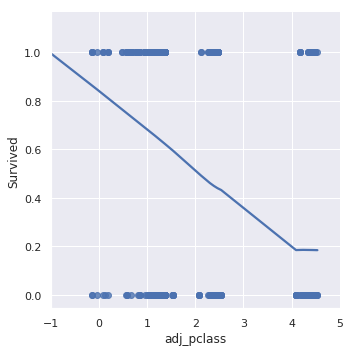

In [30]:
g = sns.lmplot(x='adj_pclass', y='Survived', data = all_data, lowess=True);
g.axes[0,0].set(xlim=(-1, 5.0))

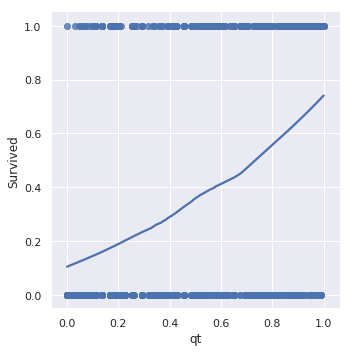

In [31]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
qt = QuantileTransformer(n_quantiles=100)
all_data['qt'] = qt.fit_transform(all_data[['Fare']])
sns.lmplot(x='qt', y='Survived', data=all_data, lowess=True);

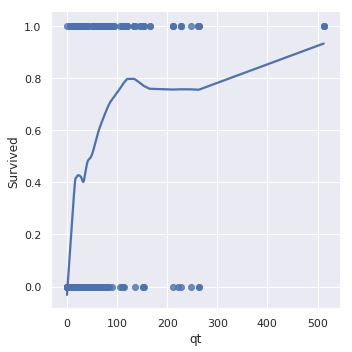

In [32]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
qt = QuantileTransformer(n_quantiles=10)
all_data['qt'] = all_data['Fare']
sns.lmplot(x='qt', y='Survived', data=all_data, lowess=True);

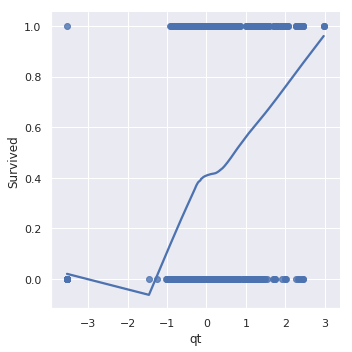

In [33]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
qt = PowerTransformer()
all_data['qt'] = qt.fit_transform(all_data[['Fare']])
sns.lmplot(x='qt', y='Survived', data=all_data, lowess=True);

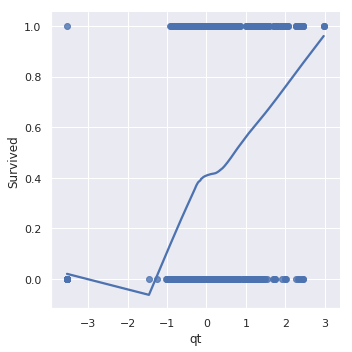

In [34]:
sns.lmplot(x='qt', y='Survived', data=all_data, lowess=True);

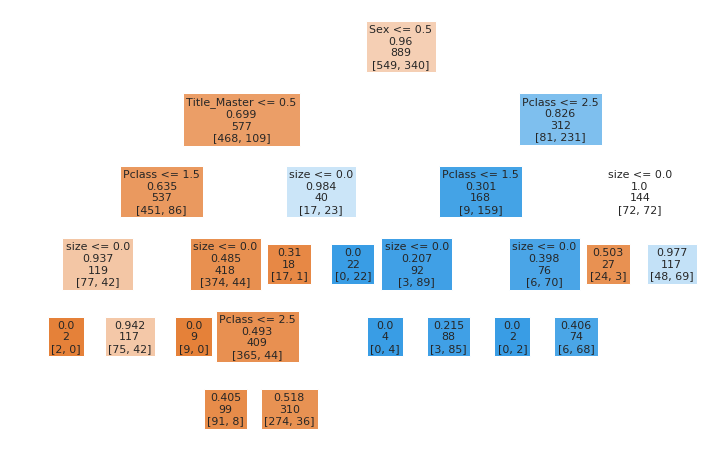

In [40]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtree = DecisionTreeClassifier(criterion = "entropy")
dtree.fit(X_prime, y)
plt.figure(figsize=[12,8])
plot_tree(dtree, label=None, feature_names=X_prime.columns,
          fontsize=11, filled=True);

In [44]:
X, y = tt.get_Xy_v5()
cols_returned, ct = tt.get_ct_v5()
X_prime = X[['Pclass', 'Sex', 'Title_Master', 'family_size']]

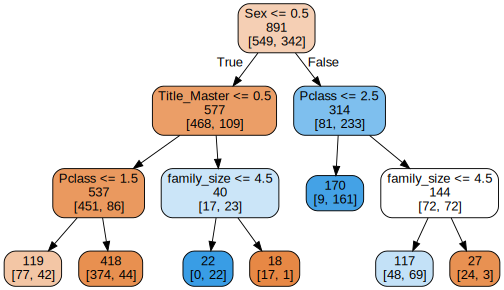

In [45]:
# conda install python-graphviz
import graphviz
import pydotplus
from graphviz import Source
from sklearn import tree
dtree = tree.DecisionTreeClassifier(criterion = "gini", random_state=707,
                                   min_samples_leaf=1, min_impurity_decrease=.003)
dtree.fit(X_prime, y)

# get the dot data
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=X_prime.columns,
                                label=None, filled=True, impurity=False,
                                rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

# adjust the plot size
pydot_graph.set_size('"7,5!"')

# display the Decision Treee
Source(pydot_graph.to_string())

In [46]:
def get_ct_v5_new():
    """Column Transform for Features

    Version 5
    * with Categorical Variable Encoding
    * use subset of variables for Wrapped IterativeImputer
    * use subset of variables for prediction

    Returns column names and ColumnTransform instance.
    """

    ss = StandardScaler()
    ii = WrappedIterativeImputer('Age')

    # Pipelines
    ss_pipe = Pipeline([('ss', ss)])
    ii_ss_pipe = Pipeline([('ii', ii), ('ss', ss)])

    # Columns to act on
    ss_cols = ['Fare']
    ii_ss_cols = ['Pclass', 'Sex', 'Age', 'Title_Master',
                  'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']
    bool_cols = ['Sex', 'is_cabin_notnull', 'Pclass', 'family_size',
                 'Port_C', 'Port_Q', 'Port_S', 'Title_Master',
                 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    transformers = [('ss_tr', ss_pipe, ss_cols),
                    ('ii_ss_tr', ii_ss_pipe, ii_ss_cols),
                    ('as_is', 'passthrough', bool_cols)]

    ct = ColumnTransformer(transformers=transformers)

    # there is no way to access the columns by name from a pipe
    # create a list of columns to keep track
    cols = ss_cols + ['Age'] + bool_cols

    return cols, ct

In [47]:
import titanic_helper_code as tt
X, y = tt.get_Xy_v5()
X.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'family_size', 'is_cabin_notnull',
       'Port_C', 'Port_Q', 'Port_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other'],
      dtype='object')

In [49]:
cols, ct = tt.get_ct_v5()
cols, ct = get_ct_v5_new()
df = pd.DataFrame(data=ct.fit_transform(X,y), columns=cols)
df.columns

Index(['Fare', 'Age', 'Sex', 'is_cabin_notnull', 'Pclass', 'family_size',
       'Port_C', 'Port_Q', 'Port_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other'],
      dtype='object')

In [50]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'family_size', 'is_cabin_notnull',
       'Port_C', 'Port_Q', 'Port_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other'],
      dtype='object')

In [51]:
X_prime = df[['Sex', 'family_size', 'Title_Mr', 'Title_Other']]
X_prime = df[['Sex', 'Pclass', 'Fare', 'Title_Master']]

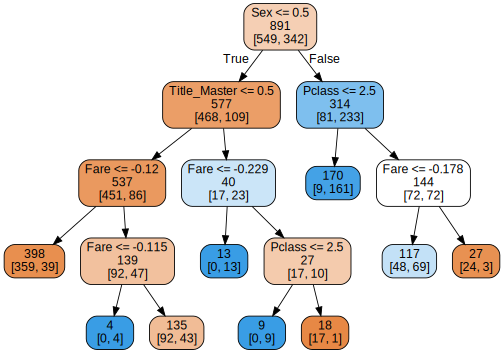

In [52]:
# conda install python-graphviz
import graphviz
import pydotplus
from graphviz import Source
from sklearn import tree
dtree = tree.DecisionTreeClassifier(criterion = "gini", random_state=707,
                                   min_samples_leaf=4, min_impurity_decrease=.003,
                                   class_weight=None)
dtree = tree.DecisionTreeClassifier(criterion = "gini", random_state=707,
                                   min_samples_leaf=4, min_impurity_decrease=.003,
                                   class_weight=None, max_leaf_nodes=15)
dtree.fit(X_prime, y)

# get the dot data
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=X_prime.columns,
                                label=None, filled=True, impurity=False,
                                rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

# adjust the plot size
pydot_graph.set_size('"7,5!"')

# display the Decision Treee
Source(pydot_graph.to_string())

In [53]:
# CV for model comparison, not model selection
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)

In [54]:
scores = cross_val_score(dtree, X_prime, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.774 max:0.845
CV Mean Score: 0.812 +/- 0.008


In [55]:
from sklearn.model_selection import GridSearchCV
params = {'min_samples_leaf':[1, 2, 3, 4, 5],
          'min_impurity_decrease': [0, 0.001, 0.002, 0.003, .004, 
                                    .005, 0.006, .007, .008],
          'criterion': ['entropy', 'gini'],
          'max_leaf_nodes': [15, 30]}
grid = GridSearchCV(estimator=dtree, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X_prime, y)
tt.print_grid(grid)

Best: 0.832 +/- 0.006
criterion: gini
max_leaf_nodes: 30
min_impurity_decrease: 0.001
min_samples_leaf: 1


In [56]:
X_prime = df[['Pclass', 'Sex', 'Title_Master', 'family_size']]

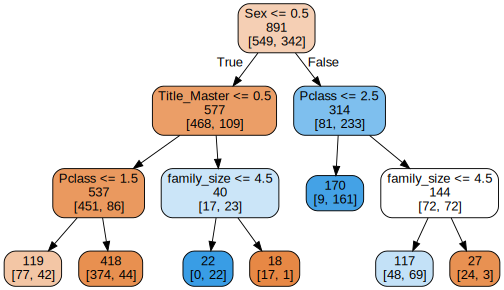

In [57]:
# conda install python-graphviz
import graphviz
import pydotplus
from graphviz import Source
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
dtree = tree.DecisionTreeClassifier(criterion = "gini", random_state=707,
                                   min_samples_leaf=4, min_impurity_decrease=.003)
dtree.fit(X_prime, y)

# get the dot data
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=X_prime.columns,
                                label=None, filled=True, impurity=False,
                                rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

# adjust the plot size
pydot_graph.set_size('"7,5!"')

# display the Decision Treee
Source(pydot_graph.to_string())

In [58]:
# CV for model comparison, not model selection
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)

In [59]:
scores = cross_val_score(dtree, X_prime, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.800 max:0.852
CV Mean Score: 0.827 +/- 0.007


In [60]:
from sklearn.model_selection import GridSearchCV
params = {'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7],
          'min_impurity_decrease': [0, 0.001, 0.002, 0.003, .004, .005],
          'criterion': ['entropy', 'gini']}
grid = GridSearchCV(estimator=dtree, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X_prime, y)
tt.print_grid(grid)

Best: 0.828 +/- 0.007
criterion: gini
min_impurity_decrease: 0.003
min_samples_leaf: 1


In [61]:
df.columns

Index(['Fare', 'Age', 'Sex', 'is_cabin_notnull', 'Pclass', 'family_size',
       'Port_C', 'Port_Q', 'Port_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other'],
      dtype='object')

In [62]:
df.dtypes

Fare                object
Age                 object
Sex                 object
is_cabin_notnull    object
Pclass              object
family_size         object
Port_C              object
Port_Q              object
Port_S              object
Title_Master        object
Title_Miss          object
Title_Mr            object
Title_Mrs           object
Title_Other         object
dtype: object

In [63]:
X_prime = df[['Sex', 'family_size', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other', 'Age']]
lr_values = np.linspace(.05, .50, 10) # for 10 estimators
lr_values

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [64]:
from xgboost import XGBClassifier
xgb_best = XGBClassifier(objective='binary:logistic', random_state=48)

params = {'n_estimators': [10], 
          'learning_rate': lr_values,
          'max_depth': [3, 4, 5, 6, 7, 8],
#           'colsample_bytree': [1.0, 0.6, 0.5, 0.4],
          'colsample_bytree': [1.0, 0.5]}
grid = GridSearchCV(estimator=xgb_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(df.astype('float'), y);

In [65]:
df_xgb = tt.print_grid(grid)

Best: 0.833 +/- 0.007
colsample_bytree: 0.5
learning_rate: 0.3
max_depth: 4
n_estimators: 10


In [66]:
list(zip(df.columns, grid.best_estimator_.feature_importances_))

[('Fare', 0.2300885),
 ('Age', 0.23893805),
 ('Sex', 0.026548672),
 ('is_cabin_notnull', 0.03539823),
 ('Pclass', 0.061946902),
 ('family_size', 0.17699115),
 ('Port_C', 0.07079646),
 ('Port_Q', 0.0),
 ('Port_S', 0.0088495575),
 ('Title_Master', 0.026548672),
 ('Title_Miss', 0.026548672),
 ('Title_Mr', 0.053097345),
 ('Title_Mrs', 0.026548672),
 ('Title_Other', 0.017699115)]

# NEW Custom RF

In [107]:
def get_ct_custom(cols):
    """Column Transform for Features

    """

    ii = WrappedIterativeImputer('Age')

    # Pipelines
    ii_pipe = Pipeline([('ii', ii)])

    # Columns to act on
    ii_cols = ['Pclass', 'Sex', 'Age', 'Title_Master',
                  'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    if 'Age' in cols:
        # cols.remove is an inplace operation
        # which operates on a reference
        cols = cols.copy()
        cols.remove('Age')
        transformers = [('ii_tr', ii_pipe, ii_cols),
                        ('as_is', 'passthrough', cols)]
        return_cols = ['Age'] + cols
    else:
        transformers = [('as_is', 'passthrough', cols)]
        return_cols = cols

    ct = ColumnTransformer(transformers=transformers)

    return return_cols, ct

In [71]:
cols = ['Sex', 'Pclass', 'Fare', 'Title_Master', 'Age']
X, y = tt.get_Xy_v5()
cols_returned, ct = get_ct_custom(cols)
print(cols)
print(cols_returned)
df = pd.DataFrame(data=ct.fit_transform(X,y), columns=cols)
df.columns

Columns Passed:  ['Sex', 'Pclass', 'Fare', 'Title_Master', 'Age']
['Sex', 'Pclass', 'Fare', 'Title_Master', 'Age']
['Age', 'Sex', 'Pclass', 'Fare', 'Title_Master']


Index(['Sex', 'Pclass', 'Fare', 'Title_Master', 'Age'], dtype='object')

In [72]:
# CV for model comparison, not model selection
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=108)

In [73]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'family_size', 'is_cabin_notnull',
       'Port_C', 'Port_Q', 'Port_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other'],
      dtype='object')

In [74]:
# %%timeit
cols = ['Sex', 'Pclass', 'Fare', 'Title_Master']
cols, ct = get_ct_custom(cols)
dtree = tree.DecisionTreeClassifier(random_state=707)
pipe = Pipeline([('ct', ct), ('dtree', dtree)])
scores = cross_val_score(pipe, X, y, cv=cv_select, n_jobs=-1)
tt.print_scores(scores)

Columns Passed:  ['Sex', 'Pclass', 'Fare', 'Title_Master']
20 Scores  min:0.783 max:0.843
CV Mean Score: 0.819 +/- 0.008


In [75]:
import itertools
subsets = []
for r in range(2,10):
    subsets.extend(list(itertools.combinations(X.columns, r=r)))

In [76]:
len(subsets)

14898

In [77]:
from sklearn.metrics import accuracy_score, log_loss

In [78]:
from sklearn.model_selection import cross_validate

### Multi procesing
cross_val_score can be used with n_jobs=-1 however for a single decision tree, this results in too small a unit-of-work.  Each fold is parallelized.

This can be seen as the CPU meter does not show all hardware cores (4 on this machine with 4 hyperthreads) being used.  This is in part because of the setup and tear down time of the internal job pool for cross_val_score.

As 20 folds are being evaluated, submitting this to pool.map will result in a unit-of-work that is 20 times larger.  As the pool is set up once and torn down once, that overhead is also avoided.

This yields much higher throughput, as can be seen on the CPU montior.

In [79]:
def eval_tree(s):
    cols_returned, ct = get_ct_custom(s)    
    dtree = tree.DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_validate(pipe, X, y, cv=cv_select,
                            scoring=('accuracy', 'neg_log_loss'))
    return {'acc':scores['test_accuracy'].mean(),
            'acc_std:':scores['test_accuracy'].std(),
            'logloss':scores['test_neg_log_loss'].mean(),
            'logloss_std':scores['test_neg_log_loss'].std(),
            'vars':s}

In [84]:
from collections import namedtuple
Score = namedtuple('Score', 
                   ['acc', 'acc_std', 'logloss', 'logloss_std','vars'])
def eval_tree2(s):
    cols_returned, ct = get_ct_custom(list(s))    
    dtree = tree.DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_validate(pipe, X, y, cv=cv_select,
                            scoring=('accuracy', 'neg_log_loss'))
    return Score(scores['test_accuracy'].mean(),
                 scores['test_accuracy'].std(),
                 scores['test_neg_log_loss'].mean(),
                 scores['test_neg_log_loss'].std(),
                 s)

In [ ]:
# NOTE
best_pruned['vars'] = best_pruned['vars'].apply(eval)

In [65]:
pool.close()
pool.join()

NameError: name 'pool' is not defined

In [59]:
import multiprocessing as mp
import tqdm
import time

# cpu_count includes hyperthreads
# pool = mp.Pool(mp.cpu_count()-1)
pool = mp.Pool(4)

start = time.time()
scores = list(tqdm.tqdm(
    pool.imap_unordered(eval_tree, subsets, chunksize=5), 
              total=len(subsets)))
stop = time.time()

print(f'Time: {stop-start:7.1f}')
pool.close()
pool.join()

100%|██████████| 14898/14898 [1:06:00<00:00,  3.76it/s]

Time:  3960.7


In [62]:
# save it
scores_df = pd.DataFrame(scores)
scores_df.to_csv('data/tree_scores.csv', index=False)

# Process It

In [309]:
tree_scores = pd.read_csv('data/tree_scores.csv')
tree_scores.head()

,acc,acc_std:,logloss,logloss_std,vars
0,0.794286,0.015158,-2.083050,0.487815,"('Pclass', 'family_size', 'Port_C', 'Port_Q', ..."
1,0.806847,0.015397,-5.029473,0.598914,"('Pclass', 'Sex', 'Fare', 'family_size', 'Port..."
2,0.740056,0.030224,-8.739391,0.995855,"('Sex', 'Age', 'Fare', 'is_cabin_notnull', 'Po..."
3,0.666547,0.011742,-0.647531,0.038917,"('Pclass', 'Title_Other')"
4,0.782382,0.019567,-5.670373,0.658846,"('Pclass', 'Fare', 'family_size', 'Port_C', 'P..."


In [124]:
tree_scores['vars'] = tree_scores['vars'].apply(eval)

TypeError: eval() arg 1 must be a string, bytes or code object

In [311]:
pd.set_option('max_colwidth', 80)

In [313]:
tree_scores.sort_values(by='acc', ascending=False).vars.head(8)

7803                     ('family_size', 'is_cabin_notnull', 'Title_Mr', 'Title_Other')
8802                              ('Pclass', 'Sex', 'Port_C', 'Port_Q', 'Title_Master')
12348    ('family_size', 'is_cabin_notnull', 'Title_Master', 'Title_Mr', 'Title_Other')
14433                                            ('Sex', 'family_size', 'Title_Master')
13209                                ('Sex', 'family_size', 'Title_Master', 'Title_Mr')
3773                  ('Sex', 'family_size', 'Title_Master', 'Title_Mr', 'Title_Other')
10692                                 ('Sex', 'family_size', 'Title_Mr', 'Title_Other')
6848                    ('Pclass', 'Sex', 'Port_C', 'Port_Q', 'Port_S', 'Title_Master')
Name: vars, dtype: object

In [199]:
tree_scores.shape

(14898, 5)

In [299]:
filter = (tree_scores['vars'].apply(len) == 7)
best = tree_scores[filter]
filter.sum()

3432

In [300]:
best = best.nlargest(n=2574, columns=['acc'])
best.shape

(2574, 5)

In [250]:
best = tree_scores.nlargest(n=7449, columns=['acc'])
best.head(3)

,acc,acc_std:,logloss,logloss_std,vars
7803,0.826157,0.015110,-0.948532,0.261608,"(family_size, is_cabin_notnull, Title_Mr, Titl..."
8802,0.825820,0.008512,-0.563845,0.114406,"(Pclass, Sex, Port_C, Port_Q, Title_Master)"
12348,0.825820,0.015006,-0.987773,0.276946,"(family_size, is_cabin_notnull, Title_Master, ..."


In [218]:
# remove supersets with scores that are <= to subset
delete_set = set()
delete_idx = set()
for i in range(len(best)):
    print(i, end=", ")
    for j in range(i+1, len(best)):
        vars1 = best.iloc[i]['vars']
        score1 = best.iloc[i]['acc']
        vars2 = best.iloc[j]['vars']
        score2 = best.iloc[j]['acc']
        
        if set(vars1) > set(vars2) and score1 <= score2:
            delete_set.add(vars1)
            delete_idx.add(i)
        elif set(vars2) > set(vars1) and score2 <= score1:
            delete_set.add(vars2)
            delete_idx.add(j)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [219]:
best_pruned = best.drop(best.index[list(delete_idx)])
best_pruned.sort_values(by='acc', ascending=False)['vars'].head()

7803     (family_size, is_cabin_notnull, Title_Mr, Titl...
8802           (Pclass, Sex, Port_C, Port_Q, Title_Master)
14433                     (Sex, family_size, Title_Master)
10692            (Sex, family_size, Title_Mr, Title_Other)
3243           (Pclass, Sex, Port_C, Port_S, Title_Master)
Name: vars, dtype: object

In [301]:
best_pruned = best
best_pruned.shape

(2574, 5)

In [302]:
acc_trees = []
for i, s in enumerate(best_pruned['vars']):
    cols_returned, ct = get_ct_custom(list(s))    
    dtree = tree.DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    acc_trees.append((f'{i}', pipe))

In [303]:
# easier if trees are saved during evaluation
# otherwise must instantiate tree per subset (each row of vars)
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(acc_trees, voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select, n_jobs=-1)
tt.print_scores(scores)

20 Scores  min:0.805 max:0.856
CV Mean Score: 0.832 +/- 0.006


In [288]:
# easier if trees are saved during evaluation
# otherwise must instantiate tree per subset (each row of vars)
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(acc_trees, voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select, n_jobs=-1)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.852
CV Mean Score: 0.832 +/- 0.006


### LogLoss

In [143]:
tree_scores.shape

(14898, 5)

In [230]:
best = tree_scores.nlargest(n=5, columns=['logloss'])
best.head()

,acc,acc_std:,logloss,logloss_std,vars
8777,0.791706,0.015055,-0.460189,0.019139,"(Sex, is_cabin_notnull, Title_Master)"
14513,0.781041,0.013837,-0.461192,0.015978,"(Pclass, Title_Mr)"
1103,0.779916,0.012044,-0.462270,0.017651,"(Pclass, Title_Master, Title_Mr)"
11981,0.790802,0.009552,-0.462462,0.075582,"(Pclass, Sex, Title_Master)"
11987,0.795749,0.018117,-0.467065,0.021391,"(Sex, is_cabin_notnull, Title_Mr)"


In [159]:
# remove supersets with scores that are <= to subset
delete_set = set()
delete_idx = set()
for i in range(len(best)):
    print(i, end=", ")
    for j in range(i+1, len(best)):
        vars1 = best.iloc[i]['vars']
        score1 = best.iloc[i]['logloss']
        vars2 = best.iloc[j]['vars']
        score2 = best.iloc[j]['logloss']
        
        if set(vars1) > set(vars2) and score1 <= score2:
            delete_set.add(vars1)
            delete_idx.add(i)
        elif set(vars2) > set(vars1) and score2 <= score1:
            delete_set.add(vars2)
            delete_idx.add(j)

0, 1, 2, 3, 4, 

In [160]:
len(delete_idx)

1

In [161]:
best_pruned = best.drop(best.index[list(delete_idx)])
best_pruned.sort_values(by='logloss', ascending=False)['vars'].head()
# best_pruned[['acc', 'vars']].head()

8777     (Sex, is_cabin_notnull, Title_Master)
14513                       (Pclass, Title_Mr)
11981              (Pclass, Sex, Title_Master)
11987        (Sex, is_cabin_notnull, Title_Mr)
Name: vars, dtype: object

In [231]:
best_pruned = best

In [232]:
logloss_trees = []
for i, s in enumerate(best_pruned['vars']):
    cols_returned, ct = get_ct_custom(list(s))    
    dtree = tree.DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    logloss_trees.append((f'{i}', pipe))

In [233]:
# easier if trees are saved during evaluation
# otherwise must instantiate tree per subset (each row of vars)
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(logloss_trees, voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select, n_jobs=-1)
tt.print_scores(scores)

20 Scores  min:0.769 max:0.829
CV Mean Score: 0.795 +/- 0.009


In [75]:
from collections import namedtuple
Score = namedtuple('Score', ['acc', 'acc_std', 'logloss',
                   'logloss_std','vars'])

score = Score(.78, .12, -0.23, 0.03, vars=('a', 'b', 'c'))
print(score)

score_list = [score, score]

df = pd.DataFrame.from_records(score_list, columns=Score._fields)
df

Score(acc=0.78, acc_std=0.12, logloss=-0.23, logloss_std=0.03, vars=('a', 'b', 'c'))


,acc,acc_std,logloss,logloss_std,vars
0,0.78,0.12,-0.23,0.03,"(a, b, c)"
1,0.78,0.12,-0.23,0.03,"(a, b, c)"


In [69]:
import multiprocessing as mp
import tqdm
import time

# cpu_count includes hyperthreads
# pool = mp.Pool(mp.cpu_count()-1)
pool = mp.Pool(4)

start = time.time()
scores = list(tqdm.tqdm(
    pool.imap_unordered(eval_tree2, subsets[:200], chunksize=5), 
              total=len(subsets[:200])))
stop = time.time()

print(f'Time: {stop-start:7.1f}')
pool.close()
pool.join()

100%|██████████| 200/200 [00:52<00:00,  3.79it/s]

Time:    52.8


In [72]:
df = pd.DataFrame.from_records(scores, columns=Score._fields)
df.head()

,acc,acc_std,logloss,logloss_std,vars
0,0.794286,0.015158,-2.083050,0.487815,"(Pclass, family_size, Port_C, Port_Q, Title_Mr..."
1,0.806847,0.015397,-5.029473,0.598914,"(Pclass, Sex, Fare, family_size, Port_Q, Port_..."
2,0.740056,0.030224,-8.739391,0.995855,"(Sex, Age, Fare, is_cabin_notnull, Port_C, Por..."
3,0.666547,0.011742,-0.647531,0.038917,"(Pclass, Title_Other)"
4,0.782382,0.019567,-5.670373,0.658846,"(Pclass, Fare, family_size, Port_C, Port_S, Ti..."


In [73]:
df.shape

(200, 5)

In [32]:
import multiprocessing as mp

# use 1 less than the number of hardware threads
# pool = mp.Pool(mp.cpu_count()-1)

# results = pool.map(eval_tree, subsets)

In [47]:
pd.DataFrame(results)

,acc,acc_std:,logloss,logloss_std,vars
0,0.778457,0.009920,-0.490581,0.072929,"(Pclass, Sex)"
1,0.669363,0.014082,-5.421212,0.541634,"(Pclass, Age)"
2,0.669357,0.014828,-6.062148,0.649772,"(Pclass, Fare)"
3,0.690453,0.013063,-0.800278,0.214340,"(Pclass, family_size)"
4,0.680354,0.014775,-0.697945,0.170219,"(Pclass, is_cabin_notnull)"
5,0.667557,0.014857,-0.612203,0.013445,"(Pclass, Port_C)"
6,0.664081,0.016717,-0.702186,0.082699,"(Pclass, Port_Q)"
7,0.669239,0.015970,-0.606641,0.013538,"(Pclass, Port_S)"
8,0.678329,0.016816,-0.604772,0.011582,"(Pclass, Title_Master)"
9,0.699333,0.012788,-0.600180,0.067327,"(Pclass, Title_Miss)"


In [36]:
trees_tmp = []
cnt = 0
print_freq = len(subsets) // 100
for s in subsets:
    
    # cheap progress meter
    if not (cnt % print_freq):
        print(f'Percent Complete: {100*cnt/len(subsets):3.1f}%')
    cnt += 1
        
    cols_returned, ct = get_ct_custom(list(s))    
    dtree = tree.DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_validate(pipe, X, y, cv=cv_select, n_jobs=-1,
                            scoring=('accuracy', 'neg_log_loss'))
    trees_tmp.append({'acc':scores['test_accuracy'].mean(),
                      'acc_std:':scores['test_accuracy'].std(),
                      'logloss':scores['test_neg_log_loss'].mean(),
                      'logloss_std':scores['test_neg_log_loss'].std(),
                      'vars':s})

KeyboardInterrupt: 

In [86]:
len(subsets)

14898

In [84]:
dtrees = pd.DataFrame(trees_tmp)
dtrees.shape

(10, 5)

In [46]:
trees_proba = []
for s in subsets[:1]:
    cols_returned, ct = get_ct_custom(list(s))    
    dtree = tree.DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_val_score(pipe, X, y, cv=cv_select, scoring='neg_log_loss')    

    trees_proba.append({'scores_mean':scores.mean(), 'scores_std':scores.std(),
                  'vars':s})
    if scores.mean() > .822:
        print(f'{s}: {scores.mean():.3f}')

In [47]:
trees_proba[0]

{'scores_mean': -0.49058097900475967,
 'scores_std': 0.07292922036185788,
 'vars': ('Pclass', 'Sex')}

In [33]:
t2 = pd.DataFrame(data=trees)
t2.to_csv('data/tree_accuracy.csv', index=False)

In [701]:
# need to impute age
trees_proba = []
for s in subsets:
    dtree = tree.DecisionTreeClassifier(random_state=707)
    preds = cross_val_predict(dtree, df[list(s)], y, cv=cv_predict, 
                              n_jobs=-1, method='predict_proba')[:, 1]
    score = -log_loss(y, preds)
    trees_proba.append({'score':score, 'vars':s, 'pred':preds})

In [702]:
t_proba = pd.DataFrame(trees_proba)

In [606]:
t = pd.DataFrame(trees)
t.head()

,pred,score,vars
0,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, ...",0.641975,"(Fare, Age)"
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.763187,"(Fare, Sex)"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.655443,"(Fare, is_cabin_notnull)"
3,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.661055,"(Fare, Pclass)"
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.647587,"(Fare, family_size)"


In [712]:
best_proba = t_proba.nlargest(n=100, columns=['score'])

In [713]:
best = t.nlargest(n=100, columns=['score'])
best.shape

(100, 3)

In [717]:
delete_set = set()
delete_idx = set()
for i in range(len(best)):
#     if i%10 == 0:
#         print(i, end=", ")
    for j in range(i+1, len(best)):
        vars1 = best_proba.iloc[i]['vars']
        score1 = best_proba.iloc[i]['score']
        vars2 = best_proba.iloc[j]['vars']
        score2 = best_proba.iloc[i]['score']
        if set(vars1) > set(vars2) and score1 <= score2:
            delete_set.add(vars1)
            delete_idx.add(i)

In [715]:
# remove supersets with scores that are <= to subset
delete_set = set()
delete_idx = set()
for i in range(len(best)):
#     if i%10 == 0:
#         print(i, end=", ")
    for j in range(i+1, len(best)):
        vars1 = best.iloc[i]['vars']
        score1 = best.iloc[i]['score']
        vars2 = best.iloc[j]['vars']
        score2 = best.iloc[i]['score']
        if set(vars1) > set(vars2) and score1 <= score2:
            delete_set.add(vars1)
            delete_idx.add(i)

In [716]:
len(delete_set), len(delete_idx)

(48, 48)

In [658]:
best['vars'].isin(delete_set)

1188     False
3114     False
3133     False
3135     False
12483     True
12486     True
14746     True
3130     False
5808      True
5810      True
6190     False
6191     False
6192     False
6193     False
6194     False
9165      True
9434      True
9744     False
12481     True
12488     True
12493     True
12496     True
14744     True
14745     True
14751     True
2721      True
2723      True
2728      True
2815     False
2820     False
         ...  
2898     False
2899     False
2904     False
2922     False
5878     False
5880     False
5888     False
5898     False
5900     False
5901     False
5903     False
5905     False
5907     False
5919     False
5922     False
6363     False
9162     False
9164     False
9166     False
9180     False
9193     False
9200     False
9436     False
9442     False
9443     False
9450     False
9452     False
9479     False
9481     False
9490     False
Name: vars, Length: 200, dtype: bool

In [718]:
best_proba_pruned = best_proba[~best_proba['vars'].isin(delete_set)]

In [667]:
best_proba = t_proba

(84, 3)

In [719]:
base_learners_proba = []
for vars in best_proba_pruned['vars']:
    base_learners_proba.append((vars, dtree.fit(df[list(vars)], y)))

In [689]:
base_learners = []
for vars in best_pruned['vars']:
    base_learners.append((vars, dtree.fit(df[list(vars)], y)))

In [690]:
len(base_learners)

84

In [720]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(base_learners_proba, voting='soft')

In [721]:
scores = cross_val_score(estimator=vc, X=df, y=y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.710 max:0.800
CV Mean Score: 0.768 +/- 0.012


In [708]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(base_learners, voting='hard')

In [709]:
scores = cross_val_score(estimator=vc, X=df, y=y, cv=cv_select, scoring='accuracy')
tt.print_scores(scores)

20 Scores  min:0.710 max:0.800
CV Mean Score: 0.768 +/- 0.012


In [669]:
for vars in best_pruned['vars']:
    print()
    for var in vars:
        print(var)


is_cabin_notnull
family_size
Title_Mr
Title_Other

is_cabin_notnull
family_size
Port_Q
Title_Mr
Title_Other

is_cabin_notnull
family_size
Title_Miss
Title_Mr
Title_Other

is_cabin_notnull
family_size
Title_Mr
Title_Mrs
Title_Other

is_cabin_notnull
family_size
Title_Master
Title_Mr
Title_Other

is_cabin_notnull
family_size
Title_Master
Title_Miss
Title_Mr
Title_Mrs

is_cabin_notnull
family_size
Title_Master
Title_Miss
Title_Mr
Title_Other

is_cabin_notnull
family_size
Title_Master
Title_Miss
Title_Mrs
Title_Other

is_cabin_notnull
family_size
Title_Master
Title_Mr
Title_Mrs
Title_Other

is_cabin_notnull
family_size
Title_Miss
Title_Mr
Title_Mrs
Title_Other

is_cabin_notnull
family_size
Title_Master
Title_Miss
Title_Mr
Title_Mrs
Title_Other

Sex
Pclass
Port_C
Port_Q
Title_Master

Sex
Pclass
Port_C
Port_S
Title_Master

is_cabin_notnull
family_size
Port_Q
Title_Master
Title_Mr
Title_Other

is_cabin_notnull
family_size
Port_Q
Title_Mr
Title_Mrs
Title_Other

Sex
Pclass
Port_C
Port_Q
Title_

In [654]:
best_pruned = best.drop(best.index[list(delete_idx)])
best_pruned

,pred,score,vars
1188,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.832772,"(is_cabin_notnull, family_size, Title_Mr, Titl..."
3114,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.831650,"(is_cabin_notnull, family_size, Port_Q, Title_..."
3133,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.831650,"(is_cabin_notnull, family_size, Title_Miss, Ti..."
3135,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.831650,"(is_cabin_notnull, family_size, Title_Mr, Titl..."
3130,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.830527,"(is_cabin_notnull, family_size, Title_Master, ..."
6190,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.830527,"(is_cabin_notnull, family_size, Title_Master, ..."
6191,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.830527,"(is_cabin_notnull, family_size, Title_Master, ..."
6192,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.830527,"(is_cabin_notnull, family_size, Title_Master, ..."
6193,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.830527,"(is_cabin_notnull, family_size, Title_Master, ..."
6194,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.830527,"(is_cabin_notnull, family_size, Title_Miss, Ti..."


In [635]:
best.['vars'] 

{('Pclass',
  'Port_C',
  'Port_Q',
  'Port_S',
  'Title_Miss',
  'Title_Mr',
  'Title_Other'),
 ('Sex', 'Pclass', 'Port_C', 'Port_Q', 'Port_S', 'Title_Master', 'Title_Miss'),
 ('Sex',
  'Pclass',
  'Port_C',
  'Port_Q',
  'Port_S',
  'Title_Master',
  'Title_Miss',
  'Title_Mrs'),
 ('Sex', 'Pclass', 'Port_C', 'Port_Q', 'Port_S', 'Title_Master', 'Title_Mrs'),
 ('Sex', 'Pclass', 'Port_C', 'Port_Q', 'Title_Master', 'Title_Miss'),
 ('Sex',
  'Pclass',
  'Port_C',
  'Port_Q',
  'Title_Master',
  'Title_Miss',
  'Title_Mr',
  'Title_Mrs',
  'Title_Other'),
 ('Sex',
  'Pclass',
  'Port_C',
  'Port_Q',
  'Title_Master',
  'Title_Miss',
  'Title_Mr',
  'Title_Other'),
 ('Sex',
  'Pclass',
  'Port_C',
  'Port_Q',
  'Title_Master',
  'Title_Miss',
  'Title_Mrs'),
 ('Sex',
  'Pclass',
  'Port_C',
  'Port_Q',
  'Title_Master',
  'Title_Miss',
  'Title_Mrs',
  'Title_Other'),
 ('Sex',
  'Pclass',
  'Port_C',
  'Port_Q',
  'Title_Master',
  'Title_Miss',
  'Title_Other'),
 ('Sex', 'Pclass', 'Port_C'

In [628]:
print(type(best.iloc[0]['vars']))
s = set()
s.add((1, 2))
s.add((1, 3))
s

<class 'tuple'>


{(1, 2), (1, 3)}

In [632]:
s.add(best.iloc[0]['vars'])
s.add(best.iloc[1]['vars'])
s

{('is_cabin_notnull', 'family_size', 'Port_Q', 'Title_Mr', 'Title_Other'),
 ('is_cabin_notnull', 'family_size', 'Title_Mr', 'Title_Other'),
 (1, 2),
 (1, 3)}

In [ ]:
for i in range(len(trees)):
    for j in range(i+1, len(trees)):
        s1 = set(trees.iloc[i]['vars'])
        s2 = set(trees.iloc[j]['vars'])
        if s1 > s2:
            print(s1, s2)

In [467]:
# easy way to get iloc values for best
list(itertools.combinations(range(5), 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

In [529]:
df.shape, df.index

((891, 14), RangeIndex(start=0, stop=891, step=1))

In [541]:
df.isna().any().any()

False

In [540]:
df.dtypes

Fare                float64
Age                 float64
Sex                 float64
is_cabin_notnull    float64
Pclass              float64
family_size         float64
Port_C              float64
Port_Q              float64
Port_S              float64
Title_Master        float64
Title_Miss          float64
Title_Mr            float64
Title_Mrs           float64
Title_Other         float64
dtype: object

In [534]:
a = (np.zeros(df.shape)).fill(-99)
a

In [556]:
df_copy.predict.value_counts()

0    566
1    325
Name: predict, dtype: int64

In [558]:
df_copy[['predict']].shape

(891, 1)

In [559]:
df.shape

(891, 14)

In [560]:
len(df)

891

[Trees](https://medium.com/@srnghn/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)  
Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

In [593]:
from sklearn.metrics import accuracy_score

dtree = DecisionTreeClassifier(random_state=505)
df_pred = pd.DataFrame(data=np.zeros((len(df), 1)), columns=['predict'])

importance = []

score_per_fold = []
for train_idx, test_idx in cv_predict.split(df,y):
    
    # train subset
    X_train = df.iloc[train_idx, :]
    y_train = y.iloc[train_idx]
    
    # test subset
    X_test = df.iloc[test_idx, :]
    y_test = y.iloc[test_idx]
    
    # fit model on train
    dtree.fit(X_train, y_train)
    importance.append(dict(zip(df.columns, dtree.feature_importances_)))
    print(list(zip(df.columns, dtree.feature_importances_)))
    print()
    
    # predict using fitted model on test
    predictions = dtree.predict(X_test)
    df_pred.loc[test_idx, 'predict'] = predictions
    
    # evaluate accuracy
    fold_score = accuracy_score(y_test, predictions)
    score_per_fold.append(fold_score)
    

importance = pd.DataFrame(importance)
scores = np.array(score_per_fold)    

print(f'{len(scores)} Scores  min:{scores.min():.3f} max:{scores.max():.3f}')
print(f'CV Mean Score: {scores.mean():.3f} +/- {scores.std()/2:.3f}')

[('Fare', 0.20738747590557807), ('Age', 0.21241540654167088), ('Sex', 0.012102850603025937), ('is_cabin_notnull', 0.018199590667806426), ('Pclass', 0.052899382959304256), ('family_size', 0.10127986213544779), ('Port_C', 0.012757058743730038), ('Port_Q', 0.014740887991531445), ('Port_S', 0.005798721265362597), ('Title_Master', 0.0), ('Title_Miss', 0.009118523728127038), ('Title_Mr', 0.3249126699339344), ('Title_Mrs', 0.0027336554450850085), ('Title_Other', 0.025653914079396038)]

[('Fare', 0.2080000809925103), ('Age', 0.2254462484847633), ('Sex', 0.010165093471976368), ('is_cabin_notnull', 0.015210921122553643), ('Pclass', 0.06404828176411467), ('family_size', 0.10747001588430512), ('Port_C', 0.010781851952298532), ('Port_Q', 0.005025439469291689), ('Port_S', 0.015496969108958442), ('Title_Master', 0.0), ('Title_Miss', 0.006810449462605036), ('Title_Mr', 0.3223441168192574), ('Title_Mrs', 0.0), ('Title_Other', 0.00920053146736533)]

[('Fare', 0.1920486570536108), ('Age', 0.2247193037753

In [594]:
(df_pred.predict == cross_val_predict(dtree, df, y, cv=cv_predict)).mean()

1.0

In [595]:
dtree = DecisionTreeClassifier(random_state=505)
scores = cross_val_score(dtree, df, y, cv=cv_predict)
tt.print_scores(scores)

10 Scores  min:0.722 max:0.820
CV Mean Score: 0.768 +/- 0.015


In [599]:
importance.apply(lambda x: x==0).sum()

Age                 0
Fare                0
Pclass              0
Port_C              0
Port_Q              2
Port_S              0
Sex                 0
Title_Master        5
Title_Miss          1
Title_Mr            0
Title_Mrs           3
Title_Other         0
family_size         0
is_cabin_notnull    0
dtype: int64

In [473]:
best.iloc[0]

pred     [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...
score                                             0.817059
vars                               (family_size, Title_Mr)
Name: 60, dtype: object

In [474]:
for idx1, idx2 in list(itertools.combinations(range(len(best)),2)):
    print(idx1, idx2, pearsonr(best.iloc[idx1].pred, best.iloc[idx2].pred)[0])

0 1 0.6640078761888681
0 2 0.7355046823054908
0 3 0.9443321245442722
0 4 0.9587611515202719
0 5 0.9855923005404116
0 6 0.8089952053154728
0 7 1.0
0 8 0.9878606018896454
0 9 0.98797139125665
0 10 0.9927559923676732
0 11 0.9951616429294103
0 12 1.0
0 13 0.9471748299400445
1 2 0.7048801915749026
1 3 0.6945536546560844
1 4 0.6817664963476661
1 5 0.6718896235603212
1 6 0.6664793595732961
1 7 0.6640078761888681
1 8 0.6651214871322967
1 9 0.6539087338429757
1 10 0.6579289377084065
1 11 0.6599487104327393
1 12 0.6640078761888681
1 13 0.6697399353475258
2 3 0.7680222174363461
2 4 0.7563027348544312
2 5 0.7458924672343604
2 6 0.8935988213537378
2 7 0.7355046823054908
2 8 0.7249617317390055
2 9 0.7316763903377737
2 10 0.7299786874264367
2 11 0.731813966381464
2 12 0.7355046823054908
2 13 0.7398264495768836
3 4 0.9852461921629527
3 5 0.9305712691728031
3 6 0.7419133273474865
3 7 0.9443321245442722
3 8 0.9365488587197567
3 9 0.9328437060333539
3 10 0.9521342856817733
3 11 0.9495314148400106
3 12 0.

In [450]:
for r in best.itertuples():
    print(k1, k2, pearsonr(preds[k1], preds[k2])[0])
    print(r.score, r.vars)

0.8170594837261503 ('family_size', 'Title_Mr')
0.8103254769921436 ('Age', 'Sex', 'Pclass')
0.8114478114478114 ('Sex', 'Pclass', 'Port_S')
0.8249158249158249 ('Sex', 'family_size', 'Title_Master')
0.8226711560044894 ('Sex', 'family_size', 'Title_Mr')
0.819304152637486 ('is_cabin_notnull', 'family_size', 'Title_Mr')
0.813692480359147 ('Pclass', 'Port_S', 'Title_Mr')
0.8170594837261503 ('family_size', 'Port_C', 'Title_Mr')
0.8181818181818182 ('family_size', 'Port_Q', 'Title_Mr')
0.8114478114478114 ('family_size', 'Port_S', 'Title_Mr')
0.813692480359147 ('family_size', 'Title_Master', 'Title_Mr')
0.8148148148148148 ('family_size', 'Title_Miss', 'Title_Mr')
0.8170594837261503 ('family_size', 'Title_Mr', 'Title_Mrs')
0.8148148148148148 ('family_size', 'Title_Mr', 'Title_Other')


In [441]:
var_series = best['vars']
preds = {}
for t in var_series:
    preds[t] = cross_val_predict(dtree, df[list(t)], y, cv=cv_predict)

In [ ]:
for k1, k2 in list(itertools.combinations(preds.keys(),2)):
    print(k1, k2, pearsonr(preds[k1], preds[k2])[0])

In [422]:
from scipy.stats import pearsonr

In [423]:
%%timeit
for k1, k2 in list(itertools.combinations(preds.keys(),2)):
    pearsonr(preds[k1], preds[k2])

1.02 ms ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [442]:
for k1, k2 in list(itertools.combinations(preds.keys(),2)):
    print(k1, k2, pearsonr(preds[k1], preds[k2])[0])

('family_size', 'Title_Mr') ('Sex', 'family_size') 0.8815118159472614
('family_size', 'Title_Mr') ('Sex', 'Title_Master') 0.8333585684450062
('family_size', 'Title_Mr') ('Pclass', 'Title_Mr') 0.6845684781958697
('family_size', 'Title_Mr') ('Sex', 'is_cabin_notnull') 0.8169762512978632
('family_size', 'Title_Mr') ('Sex', 'Port_C') 0.8169762512978632
('family_size', 'Title_Mr') ('Sex', 'Port_Q') 0.8169762512978632
('Sex', 'family_size') ('Sex', 'Title_Master') 0.8315680526498571
('Sex', 'family_size') ('Pclass', 'Title_Mr') 0.565699470339796
('Sex', 'family_size') ('Sex', 'is_cabin_notnull') 0.9167374236529239
('Sex', 'family_size') ('Sex', 'Port_C') 0.9167374236529239
('Sex', 'family_size') ('Sex', 'Port_Q') 0.9167374236529239
('Sex', 'Title_Master') ('Pclass', 'Title_Mr') 0.5573306174238218
('Sex', 'Title_Master') ('Sex', 'is_cabin_notnull') 0.9085784446696827
('Sex', 'Title_Master') ('Sex', 'Port_C') 0.9085784446696827
('Sex', 'Title_Master') ('Sex', 'Port_Q') 0.9085784446696827
('Pcl

In [425]:
%%timeit
for k1, k2 in list(itertools.combinations(preds.keys(),2)):
    np.corrcoef(preds[k1], preds[k2])

1.5 ms ± 4.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [426]:
for k1, k2 in list(itertools.combinations(preds.keys(),2)):
    print(np.corrcoef(preds[k1], preds[k2]))

[[1.         0.88151182]
 [0.88151182 1.        ]]
[[1.         0.83335857]
 [0.83335857 1.        ]]
[[1.         0.81697625]
 [0.81697625 1.        ]]
[[1.         0.81697625]
 [0.81697625 1.        ]]
[[1.         0.81697625]
 [0.81697625 1.        ]]
[[1.         0.81697625]
 [0.81697625 1.        ]]
[[1.         0.83156805]
 [0.83156805 1.        ]]
[[1.         0.91673742]
 [0.91673742 1.        ]]
[[1.         0.91673742]
 [0.91673742 1.        ]]
[[1.         0.91673742]
 [0.91673742 1.        ]]
[[1.         0.91673742]
 [0.91673742 1.        ]]
[[1.         0.90857844]
 [0.90857844 1.        ]]
[[1.         0.90857844]
 [0.90857844 1.        ]]
[[1.         0.90857844]
 [0.90857844 1.        ]]
[[1.         0.90857844]
 [0.90857844 1.        ]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]


In [307]:
len(preds[('Fare', 'Age')])

891

In [343]:
var_series = best['vars']
preds = {}
for t in var_series:
    print(t)
    preds[t] = cross_val_predict(dtree, df[list(t)], y, cv=cv_predict)

('family_size', 'Title_Mr')
('Sex', 'family_size')
('Sex', 'Title_Master')


In [360]:
var_series = best['vars']
df_preds = pd.DataFrame()
for t in var_series:
    print(t)
    predictions = cross_val_predict(dtree, df[list(t)], y, cv=cv_predict)
    df_preds = df_preds.append(pd.DataFrame(data = [[t, predictions]], 
                                 columns=['vars', 'preds']), ignore_index=True)

('family_size', 'Title_Mr')
('Sex', 'family_size')
('Sex', 'Title_Master')


In [364]:
df_preds.set_index('vars')

,preds
vars,
"(family_size, Title_Mr)","[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."
"(Sex, family_size)","[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."
"(Sex, Title_Master)","[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ..."


In [360]:
var_series = best['vars']
df_preds = pd.DataFrame()
for t in var_series:
    print(t)
    predictions = cross_val_predict(dtree, df[list(t)], y, cv=cv_predict)
    df_preds = df_preds.append(pd.DataFrame(data = [[t, predictions]], 
                                 columns=['vars', 'preds']), ignore_index=True)

('family_size', 'Title_Mr')
('Sex', 'family_size')
('Sex', 'Title_Master')


In [373]:
preds = np.zeros((3,3), dtype=bool)

In [378]:
preds[0] = [0, 0, 1]
preds[1] = [1, 0, 1]
np.corrcoef(preds[0], preds[1])

array([[1. , 0.5],
       [0.5, 1. ]])

In [381]:
preds[0] = [0, 0, 1]
preds[1] = [1, 0, 1]
np.cov(preds)

array([[0.33333333, 0.16666667, 0.        ],
       [0.16666667, 0.33333333, 0.        ],
       [0.        , 0.        , 0.        ]])

In [363]:
np.corrcoef(df_preds.loc)

TypeError: corr() missing 1 required positional argument: 'other'

In [349]:
pd.DataFrame(data=[[('a', 'b'), [1, 2, 3]]], columns=['vars', 'preds'])

,vars,preds
0,"(a, b)","[1, 2, 3]"


In [352]:
df_tmp = pd.DataFrame()
df_tmp = df_tmp.append(pd.DataFrame(data=[[('a', 'b'), [1, 2, 3]]], columns=['vars', 'preds']))
df_tmp.append(pd.DataFrame(data=[[('a', 'c'), [10, 2, 3]]], columns=['vars', 'preds']))

,vars,preds
0,"(a, b)","[1, 2, 3]"
0,"(a, c)","[10, 2, 3]"


In [345]:
df_preds.shape

(0, 0)

In [330]:
pd.DataFrame(data = [[('a', 'b'), np.array([1, 2, 3])]], columns=['vars', 'value'])

,vars,value
0,"(a, b)","[1, 2, 3]"


In [315]:
df2 = pd.DataFrame(columns=['value'])

In [321]:
df2.append(pd.DataFrame(data = [('Fare', 'Age'), 10], columns=['vars', 'value']))

TypeError: object of type 'int' has no len()

In [318]:
pd.concat(df2, [('Fare', 'Age'), 10])

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [317]:
df2.loc[('Fare', 'Age'),0] = 10
df2.loc[('Fare', 'Sex'),1] = 11
df2

KeyError: "['Age'] not in index"

In [3]:
# Custom Transform Class for Imputation
from sklearn.base import TransformerMixin
class MyTransformer(TransformerMixin): 
    '''Class with fit() and transform() methods'''

    def fit(self, X, y):
        '''
        fit() will compute and save the mean age per (pclass, sex)
        on the training data
        '''
        self.mean_age_by_pclass_sex = X.groupby(['Pclass', 'gender_male'])['Age'].mean()
        
        # return an instance of MyTransformer
        return self
    
    def transform(self, X):
        '''
        transform() is applied to both train and test data
        
        It will replace missing age values by looking up the
        mean age per (pclass,sex)
        '''
        
        # index into multi-indexed Pandas Series using 2-part key
        # Pandas does not allow indexing by DataFrame, so create list of tuples
        # each tuple is (pclass, sex)
        missing_age_idx = X['Age'].isnull()
        df = X.loc[missing_age_idx, ['Pclass', 'gender_male']]
        index_tuples = list(df.itertuples(index=False, name=None))
        
        # lookup mean age in DataFrameGroupBy using list of tuples of (pclass, sex)
        imputed_age_values = self.mean_age_by_pclass_sex.loc[index_tuples].values
        
        # replace the missing values with the imputed age values
        X = X.copy()
        X.loc[missing_age_idx, 'Age'] = imputed_age_values

        # drop the sex column as logicstic regression only works with numerics
        # (later we will encode it and use it)
        return X

In [95]:
# read in all the labeled data
all_data = pd.read_csv('./data/train.csv')

# drop string columns with too many values or too many nulls
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
all_data = all_data.drop(drop_cols, axis=1)

# drop rows with Embarked null
rows_to_keep = all_data['Embarked'].notnull()
all_data = all_data[rows_to_keep]

# one-hot encode Sex and Embarked
gender = pd.get_dummies(all_data['Sex'], drop_first=True, prefix='gender')
port = pd.get_dummies(all_data['Embarked'], drop_first=True, prefix='port')
all_data = pd.concat([all_data, gender, port], axis=1)

# remove encoded variables
all_data.drop(['Embarked', 'Sex'], axis=1, inplace=True)

# feature extraction: sibsp == 0
all_data['sibsp_zero'] = (all_data['SibSp'] == 0)

# feature extraction: parch == 0
all_data['parch_zero'] = (all_data['Parch'] == 0)

# feature extraction: sibsp == 0 & parch == 0
all_data['alone'] = (all_data['parch_zero'] & all_data['sibsp_zero'])

# feature extraction: quantize fare
def quantize_fare(fare):
    if fare < 45:
        return 0
    elif fare < 80:
        return 1
    else:
        return 2
    
all_data['fare_quantized'] = all_data['Fare'].apply(quantize_fare)
all_data['sibsp_zero'] = all_data['sibsp_zero'].astype('int')
all_data['parch_zero'] = all_data['parch_zero'].astype('int')
all_data['alone'] = all_data['alone'].astype('int')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

standard_scaler = StandardScaler()
my_transformer = MyTransformer()

In [96]:
y.describe()

count    889.000000
mean       0.382452
std        0.486260
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [97]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
Pclass            889 non-null int64
Age               712 non-null float64
SibSp             889 non-null int64
Parch             889 non-null int64
Fare              889 non-null float64
gender_male       889 non-null uint8
port_Q            889 non-null uint8
port_S            889 non-null uint8
sibsp_zero        889 non-null int64
parch_zero        889 non-null int64
alone             889 non-null int64
fare_quantized    889 non-null int64
dtypes: float64(2), int64(7), uint8(3)
memory usage: 72.1 KB


In [280]:
# read in all the labeled data
all_data = pd.read_csv('./data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# one hot encode Sex and Embarked
dummy_embarked = pd.get_dummies(X['Embarked'], drop_first=True)
dummy_sex = pd.get_dummies(X['Sex'], drop_first=True)
X = pd.concat([X, dummy_embarked, dummy_sex], axis=1)

# proposed feature extraction: sibsp == 0 & parch == 0
X['Alone'] = (X['SibSp'] == 0) & (X['Parch'] == 0)

# as per EDA notebook, binarize Age at 18 (child/adult)
# note: null values will be imputed to some value well above 18
X['Child'] = (X['Age'] < 18)

X['Test'] = (X['male']-0.5)*X['Age']

drop_fields = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']
X = X.drop(drop_fields, axis=1)
X.head(3)

,Pclass,Age,SibSp,Parch,Fare,Q,S,male,Alone,Child,Test
0,3,22.0,1,0,7.2500,0,1,1,False,False,11.0
1,1,38.0,1,0,71.2833,0,0,0,False,False,-19.0
2,3,26.0,0,0,7.9250,0,1,0,True,False,-13.0


In [246]:
k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

In [327]:
import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            n_estimators=100,n_jobs=4,) 
#                             subsample=.9, colsample_bytree = 0.9)
#                             learning_rate=0.3, reg_lambda=0.03,
#                             reg_alpha=1.0,
#                             subsample=0.7, colsample_bytree = 0.7,
#                             scale_pos_weight=1.0, max_depth=3,
#                             min_child_weight=2.0,
#                             gamma=0.0)
print(xgb_clf)

cols = ['Pclass', 'Age', 'male', 'Q', 'S']
cols = ['Pclass', 'Age', 'male']
cv_scores = []
for i in range(25):
    crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, 
                        random_state=i*1001)
    scores = cross_val_score(xgb_clf, X[cols], y, cv=crossvalidation, 
                             scoring='accuracy', n_jobs=4)
    cv_scores.extend(scores)

round(scores.mean(),3), np.round(scores.std(),3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


(0.81, 0.049)

In [273]:
xgb_clf.fit(X[cols], y)
xgb_clf.feature_importances_

array([0.21477664, 0.6168385 , 0.03092784, 0.05670103, 0.08075602],
      dtype=float32)

In [274]:
cols

['Pclass', 'Age', 'Q', 'S', 'male']

In [1]:
import pprint as pp

In [7]:
a = {'a':[1, 2], 'b': [3, 4, 5]}
for key, value in a.items():
    print(f'{key}: {value}')

a: [1, 2]
b: [3, 4, 5]


In [267]:
import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            n_estimators=100,n_jobs=7)
#                             reg_alpha=1.0)
#                             learning_rate=0.3, reg_lambda=0.03,
#                             reg_alpha=1.0,
#                             subsample=0.7, colsample_bytree = 0.7,
#                             scale_pos_weight=1.0, max_depth=3,
#                             min_child_weight=2.0,
#                             gamma=0.0)
print(xgb_clf)

# *****
# define transform pipeline for Fare
descretize = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
bin_step = ('bin', descretize)
ss_bin_pipe = Pipeline([bin_step])

# define estimator (last step in overall pipe)
xgb_step = ['xgb', xgb_clf]

# Transformer list for ColumnTransform
transformers = [('na', 'passthrough', ['Pclass',  'Age',
                                      'Q', 'S', 'male']),]
#                 ('ss_bin', ss_bin_pipe, ['Fare'])]

col_transform = ColumnTransformer(transformers=transformers)

# Transform the inputs and apply LogisticRegression
ml_pipe = Pipeline([('transform', col_transform), xgb_step])
# *****

# classifier = make_pipeline(my_transformer, xgb_clf)

cv_scores = []
for i in range(25):
    crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=i*7)
    scores = cross_val_score(ml_pipe, X, y, cv=crossvalidation, 
                             scoring='accuracy', n_jobs=7)
    cv_scores.extend(scores)

print(np.round(scores.std(),3))
print(round(scores.mean(),3))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
0.028
0.819


In [268]:
xgb_clf.feature_importances_

XGBoostError: need to call fit or load_model beforehand

In [155]:
import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            n_estimators=100, random_state=5,
                           learning_rate=0.3, reg_lambda=0.03,
                           reg_alpha=1.0,
                           subsample=0.7, colsample_bytree = 0.7,
                           scale_pos_weight=1.0, max_depth=3,
                           min_child_weight=2.0,
                           gamma=0.0)

# classifier = make_pipeline(my_transformer, xgb_clf)

scores = cross_val_score(xgb_clf, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=7)

print(np.round(scores,3))
print(round(np.mean(scores),3))

[0.778 0.911 0.787 0.809 0.876 0.809 0.865 0.742 0.787 0.841]
0.82


In [22]:
# alternative
data = xgb.DMatrix(data=X, label=y, silent=True)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic", "n_estimators":100, "random_state":5}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=data, params=params, nfold=10, num_boost_round=10, 
                    metrics="error", as_pandas=True, seed=5,
                   verbose_eval=False)

[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[17:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

In [23]:
print(cv_results)

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.138734         0.004732         0.191292        0.039013
1          0.130860         0.005836         0.193539        0.048984
2          0.125235         0.005260         0.198034        0.043321
3          0.120736         0.006025         0.196935        0.044960
4          0.118736         0.005803         0.195799        0.039147
5          0.116737         0.005534         0.196935        0.046342
6          0.115487         0.006174         0.187908        0.041162
7          0.113862         0.005154         0.187908        0.037971
8          0.112361         0.005490         0.185648        0.035909
9          0.109612         0.005544         0.186772        0.035530
